## Лабораторная работа по курсу "Искусственный интеллект"
## Многослойный персептрон

| Студент | Гамов Павел Антонович |
|---------|--------|
| Группа  | м80-407б-18      |
| Вариант | 2 |
| N | 4 |

Для начала, скачаем датасет MNIST. Используйте `wget` или `curl`, либо скачайте вручную [по ссылке](https://raw.githubusercontent.com/shwars/NeuroWorkshop/master/Data/MNIST/mnist.pkl.gz).

In [1]:
#!wget https://raw.githubusercontent.com/shwars/NeuroWorkshop/master/Data/MNIST/mnist.pkl.gz
!curl -o mnist.pkl.gz https://raw.githubusercontent.com/shwars/NeuroWorkshop/master/Data/MNIST/mnist.pkl.gz
!gzip -d mnist.pkl.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  4  9.9M    4  417k    0     0   417k      0  0:00:24 --:--:--  0:00:24  513k
 28  9.9M   28 2849k    0     0  2849k      0  0:00:03  0:00:01  0:00:02 1571k
 51  9.9M   51 5249k    0     0  2624k      0  0:00:03  0:00:02  0:00:01 1866k
 75  9.9M   75 7681k    0     0  2560k      0  0:00:03  0:00:03 --:--:-- 2014k
 99  9.9M   99  9.8M    0     0  2516k      0  0:00:04  0:00:04 --:--:-- 2091k
100  9.9M  100  9.9M    0     0  2537k      0  0:00:04  0:00:04 --:--:-- 2423k
"gzip" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.


Теперь загружаем датасет:

In [2]:
import numpy as np
import matplotlib.pyplot as plt 
import pickle
with open('mnist.pkl','rb') as f:
    MNIST = pickle.load(f)

In [3]:
data = MNIST['Train']['Features']
labels = MNIST['Train']['Labels']

Смотрим на то, какие данные получились:

In [4]:
data.shape, labels.shape

((42000, 784), (42000,))

Приводим labels к виду векторов размера 10

In [5]:
y = [[0]*10 for i in labels]
for i in range(labels.size):
    y[i][labels[i]] = 1
labels = np.array(y)

Используйте Scikit Learn для разбиения данных на обучающую и тестовую выборку

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
x_train, x_test, y_train, y_test = train_test_split(data,labels,test_size=0.2,train_size=0.8)

In [7]:
x_train = np.array([data / 255 for data in x_train])
x_test = np.array([data / 255 for data in x_test])

In [8]:
x_train.shape, y_train.shape

((33600, 784), (33600, 10))

In [9]:
x_test.shape, y_test.shape

((8400, 784), (8400, 10))

Многослойная сеть

In [ ]:
class Linear:
    def __init__(self,nin,nout):
        self.W = np.random.normal(0, 1.0/np.sqrt(nin), (nout, nin))
        self.b = np.zeros((1,nout)) # сдвиг
        
    def forward(self, x):
        self.x = x
        return np.dot(x, self.W.T) + self.b
    
    def backward(self, dz):
        dx = np.dot(dz, self.W)
        dW = np.dot(dz.T, self.x)
        db = dz.sum(axis=0)
        self.dW = dW
        self.db = db
        return dx
    
    def update(self,lr):
        self.W -= lr*self.dW
        self.b -= lr*self.db

In [11]:
class Softmax:
    def forward(self,z):
        self.z = z
        zmax = z.max(axis=1,keepdims=True)
        expz = np.exp(z-zmax)
        Z = expz.sum(axis=1,keepdims=True)
        return expz / Z
    
    def backward(self,dp):
        p = self.forward(self.z)
        pdp = p * dp
        return pdp - p * pdp.sum(axis=1, keepdims=True)

In [12]:
class Tanh:
    def forward(self,x):
        y = np.tanh(x)
        self.y = y
        return y
    def backward(self,dy):
        return (1.0-self.y**2)*dy

In [13]:
class CrossEntropyLoss:
    def forward(self,p,y):
        self.p = p
        self.y = y
        p = np.clip(p, 1e-12, 1. - 1e-12)
        return -np.mean(np.multiply(y, np.log(p)) + np.multiply((1-y), np.log(1-p)))
    
    def backward(self,loss):
        return self.p - self.y

In [19]:
class Net:
    def __init__(self):
        self.layers = []
    
    def add(self,l):
        self.layers.append(l)
        
    def forward(self,x):
        for l in self.layers:
            x = l.forward(x)
        return x
    
    def backward(self,z):
        for l in self.layers[::-1]:
            z = l.backward(z)
        return z
    
    def update(self,lr):
        for l in self.layers:
            if 'update' in l.__dir__():
                l.update(lr)
    
    def compile(self, loss=None, metrics=["accuracy"]):
        self.loss = loss
        self.metrics = metrics
    
    def get_loss_acc(self, x, y):
        p = self.forward(x)
        l = self.loss.forward(p,y)
        true_label = np.argmax(y,axis=1)
        pred_label = np.argmax(p,axis=1)
        acc = (pred_label==true_label).mean()
        return l, acc
    
    def get_conf_mat(self, x, y):
        p = self.forward(x)
        true_label = np.argmax(y,axis=1)
        pred_label = np.argmax(p,axis=1)
        return confusion_matrix(pred_label, true_label)
    
    
    def fit(self, X_train, y_train, batch_size=4, epochs=5, validation_data=None, lr=0.3):
        X_test, y_test = validation_data
        history = []
        train_loss, train_acc = self.get_loss_acc(X_train, y_train)
        test_loss, test_acc = self.get_loss_acc(X_test, y_test)
        history.append([train_acc,train_loss,test_acc,test_loss])
        
        for i in range(4):
            print(f"Initial {['train_acc','train_loss','test_acc','test_loss'][i]}: {history[-1][i]}")

        for epo in range(epochs):
            for i in range(0,len(X_train),batch_size):
                xb = X_train[i:i+batch_size]
                yb = y_train[i:i+batch_size]
                p = self.forward(xb)
                l = self.loss.forward(p,yb)
                dp = self.loss.backward(l)
                dx = self.backward(dp)
                net.update(lr)
            train_loss, train_acc = self.get_loss_acc(X_train, y_train)
            test_loss, test_acc = self.get_loss_acc(X_test, y_test)
            history.append([train_acc,train_loss,test_acc,test_loss])
            print(f"epoch: {epo+1}/{epochs}")
            for i in range(4):
                print(f"{['train_acc','train_loss','test_acc','test_loss'][i]}: {history[-1][i]}")
            print("confusion matrix:", self.get_conf_mat(X_train, y_train), sep='\n')
        return history

Однослойная сеть

In [20]:
net = Net()
net.add(Linear(x_test.shape[-1], y_test.shape[-1]))
net.add(Softmax())
net.compile(loss=CrossEntropyLoss())

hist = net.fit(x_train, y_train, lr=0.001, epochs=5, batch_size=256, validation_data=(x_test, y_test))

Initial train_acc: 0.06729166666666667
Initial train_loss: 0.33598706317527804
Initial test_acc: 0.06202380952380952
Initial test_loss: 0.3359738262701876
epoch: 1/5
train_acc: 0.8421428571428572
train_loss: 0.12012574425295806
test_acc: 0.8463095238095238
test_loss: 0.11941711457401256
confusion matrix:
[[3091    0   41   30   12   89   50   42   25   45]
 [   0 3512   81   40   48  127   40  122  123   42]
 [  15   22 2741  132   18   32   56   80   44   35]
 [   9   14   56 2871    4  389    6   11  164   57]
 [   6    1   75    8 2794   85   38   64   33  197]
 [  33   25    4   75    2 1865   40    2   78   12]
 [  60   11  135   43   46  113 3047    9   38    7]
 [   4    4   75   59    8   40    1 3050   31  177]
 [  46  146  110  164   62  204   34   28 2635   65]
 [   5    1   25   71  273   92    0  147   91 2690]]
epoch: 2/5
train_acc: 0.8726190476190476
train_loss: 0.09188553639304366
test_acc: 0.8735714285714286
test_loss: 0.09144730170820047
confusion matrix:
[[3123    1 

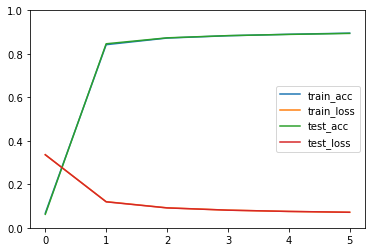

In [21]:
plt.clf()
plt.ylim(0, 1.0)
for i in range(4):
    plt.plot([val[i] for val in hist], label=['train_acc','train_loss','test_acc','test_loss'][i])
plt.legend()

In [22]:
# многослойная
net = Net()
net.add(Linear(x_test.shape[-1], 16))
net.add(Tanh())
net.add(Linear(16, y_test.shape[-1]))
net.add(Softmax())

net.compile(loss=CrossEntropyLoss())

hist = net.fit(x_train, y_train, lr=0.001, epochs=5, batch_size=256, validation_data=(x_test, y_test))

Initial train_acc: 0.12675595238095239
Initial train_loss: 0.3314240017276368
Initial test_acc: 0.1270238095238095
Initial test_loss: 0.33204135199787077
epoch: 1/5
train_acc: 0.8096130952380952
train_loss: 0.15421981744433466
test_acc: 0.8136904761904762
test_loss: 0.15409815483569939
confusion matrix:
[[3083    0  120   44   16  161   99   27   51   45]
 [   1 3672  268   48   96  141   52  112  277   39]
 [  15    9 1983   81    6   30   11   23  127    8]
 [  16   10  316 2950    2  301    0   17  213   57]
 [   4    0  102    4 2634   72   26   32   37  207]
 [  24   13   13  106    6 2097   84    5  265   15]
 [  39   11  225   34   79   91 3031    5   67   10]
 [  10    5   91   62   36   58    3 3121   46  301]
 [  72   15  117   61   10   48    5    8 2013   26]
 [   5    1  108  103  382   37    1  205  166 2619]]
epoch: 2/5
train_acc: 0.8720833333333333
train_loss: 0.10183765837657376
test_acc: 0.8686904761904762
test_loss: 0.10180954666942249
confusion matrix:
[[3122    0  

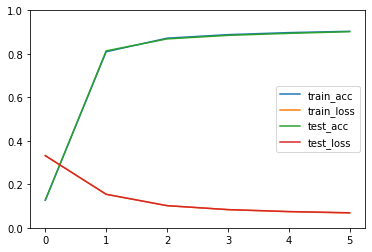

In [23]:
plt.clf()
plt.ylim(0, 1.0)
for i in range(4):
    plt.plot([val[i] for val in hist], label=['train_acc','train_loss','test_acc','test_loss'][i])
plt.legend()